In [1]:
%reset-f
%load_ext autoreload
%autoreload
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
import sys

from scipy.stats import gaussian_kde

from IPython.display import clear_output

In [2]:
debug=True
if debug:
    plt.rcParams["savefig.dpi"]=45
else:
    plt.rcParams["savefig.dpi"]=90

In [3]:
out_folder = "scorecards/"
os.makedirs(out_folder,exist_ok=True)

#Data

In [4]:
def normalizer(s):
    return (s-s.min())/(s.max()-s.min())

In [5]:
#Read inputs
df_original = pd.read_csv("df.csv").drop("iso3",axis=1).set_index("country").dropna()

df_with_sens = df_original.append(pd.read_csv("df_sensit_results.csv").drop("iso3",axis=1).set_index("country").dropna())

df_original.dropna(inplace=True) 

deriv_resilience=pd.read_csv("deriv.csv").rename(columns={"Unnamed: 0":"country"}).set_index("country")
deriv_risk =pd.read_csv("deriv_risk.csv").rename(columns={"Unnamed: 0":"country"}).set_index("country")

info = pd.read_csv("inputs_info.csv").set_index("key")

In [6]:
#upper and lower bounds
lower_bound = df_original.min()
upper_bound = df_original.max()

single_values_set = (lower_bound == upper_bound).replace(False,np.nan).dropna().index.tolist()

lower_bound[single_values_set]=info.ix[single_values_set,"lower"]
upper_bound[single_values_set]=info.ix[single_values_set,"upper"]

In [7]:
#Text for each subindicator
info = pd.read_csv("inputs_info.csv").set_index("key")
key_to_desc = info["descriptor"]

#ranks
rank=pd.read_csv("rankings.csv").set_index("country")
n=rank.values.max()

### countries to plot

In [8]:
if debug:
    country_list =[]
    #Sweden and the sensitivity analysis
    for c in df_with_sens.index:
        if "Malawi" not in c: continue
        else: country_list.append(c)
            
    #country_list=["Malawi"]       
        
else:
    country_list = df_with_sens.index#.tolist()[::-1] #from last to first


### keys to plot

In [9]:
risk_keys = ["v","fa","protection","resilience","shew"]
resilience_keys = np.setdiff1d(deriv_resilience.columns,["v","fa","faref","v_s","avg_prod_k","shew","protection","T_rebuild_L","resilience","pi","H","alpha","income_elast"])



#params

In [10]:
smallfont = {'family' : 'sans serif', 'size'   : 18}

font = {'family' : 'sans serif',
    'size'   : 22}

boldfont = {'family' : 'sans serif',
     'weight': 'bold',           
     'size'   : 22}

bigfont = {'family' : 'serif',
     'size'   : 26}
    
format_for_rank=lambda x :"{:1.0f}".format(x)

#drawing functions

###whole row

In [11]:
linewidth=1.5
height = .4

def fancy_round(x,n=2):
    """displays numbers with a given number of digits"""
    
    #special cases
    if np.isnan(x):
        return x
    
    if np.isinf(x):
        return (x)
    
    #number of digits before the dot in the original number
    if abs(x)<1:
        s=0
    else:
        s=int(np.log10(abs(x)))+1
    
    #output
    if s<n:
        return round(x,n-s)
    else:
        return int(round(x,n-s))
    
def draw_row(key,c,i,step):
    """descrption, distribution, rank and progress needed"""

    number_type = info["number_type"][key]
    

    xoc = df_with_sens.ix[c,key]

    is_single =  key in single_values_set

    if np.sign(step.ix[c,key])>0:
        color="blue"
        s=1
        difficulty = step.ix[c,key] /(upper_bound[key] -xoc)
    else:
        color="red"
        s=-1
        difficulty = step.ix[c,key]/(lower_bound[key]-xoc)

    step_color = "DarkOrange"
    if difficulty>10:
        step_color="DarKRed"
    if difficulty<1:
        step_color="DarkGreen"
    
    #format_for_der =lambda x :"{:1.2f} pt".format(x)

    if not is_single: 
        draw_distri(key,i,color,info.ix[key,"bandwith"],height,linewidth)
    
    anotate_distri(key,c,i,color)

    
    #formaters
    if number_type=="simple":
        format_for_step=lambda x :"{: g}   ".format(fancy_round(x))
    else:
        format_for_step=lambda x :"{: g} pt".format(fancy_round(100*x))
    
    #Progress needed 
    plt.text(2.75,i,format_for_step(step.ix[c,key]),fontdict=font,horizontalalignment='center',color=step_color)
         
    if not is_single:
        #rank
        r=rank.ix[df_with_sens.ix[c,"original_country"],key]
        ar=.5*(r*(s+1) + (1+n-r)*(1-s))
        the_sring = format_for_rank(ar)
    else:
        the_sring = " "
    plt.text(1.75,i,the_sring,fontdict=font,horizontalalignment='center')

    return i+.8

###distribution

In [12]:
t=np.linspace(0,1,100)

def draw_distri(key,i,color,bandwith,height,linewidth):
    """distribution"""
   
    x = (df_original[key]-lower_bound[key])/(upper_bound[key]-lower_bound[key])

    #all countries distribution
    y=gaussian_kde(x, bandwith)(t)
    y=height*y/y.max() 
    plt.plot(t, i+y,color=color,linewidth=linewidth)
    
    

def anotate_distri(key,c,i,color): 
    """dot where the country stands, bounds, and description of sub-indicator"""
    number_type=info["number_type"][key]
    
    
    if number_type=="percent":
        format_for_val=lambda x :"{:2.0f}%".format(100*x)
        format_for_bound=lambda x :"{:2.0f}".format(100*x)
    elif number_type=="small_percent":
        format_for_bound=lambda x :"{:2.0f}".format(100*x)
        format_for_val=lambda x :"{}%".format(fancy_round(100*x,2))
    elif number_type=="simple":
        format_for_val=lambda x :"{:2.0f}".format(x)
        format_for_bound=format_for_val
    elif number_type=="resilience":
        format_for_val=lambda x :"{}%".format(fancy_round(100*x,2))
        format_for_bound=lambda x :"{:2.0f}".format(100*x)
    elif number_type=="risk":
        format_for_val=lambda x :"{}%".format(fancy_round(100*x,2))
        format_for_bound=lambda x :"{:2.0f}".format(100*x)


    #Grey line
    plt.plot(t, i+0*t, color="gray",linewidth=1)
    
    #bounds
    plt.text(0-.05, i, format_for_bound(lower_bound[key]),fontdict=smallfont,horizontalalignment="right",verticalalignment="center")
    plt.text(1+.05, i, format_for_bound(upper_bound[key]),fontdict=smallfont,horizontalalignment="left" ,verticalalignment="center")
        
    #performance of this country 
    v = df_with_sens.ix[c,key]
    x = (v-lower_bound[key])/(upper_bound[key]-lower_bound[key])
        
    plt.text(x, i-.1, format_for_val(v),color=color,fontdict=font,horizontalalignment="center",verticalalignment="top")
    plt.scatter(x,i,s=50,c=color,zorder = 20)
    
    #Description
    plt.text(-.35, i, info.ix[key,"descriptor"],fontdict=font,horizontalalignment='right')      

###separator and titles

In [13]:
def draw_seprarator(i):
    """horizontal grey line"""
    sep_steps=.08
    i+=sep_steps
    ex=np.array([-2.5,3])
    plt.plot(ex, i-0.35+0*ex, color="#aaaaaa",linewidth=1,clip_on=False)
    return i+sep_steps
 

In [14]:
def write_titles(i,second_title):
    #titles
    #plt.text(5.5,i-.15,"Impact \non resilience",fontdict=font, horizontalalignment='center')
    plt.text(1.75,i-.15,"Rank",fontdict=font, horizontalalignment='center')
    plt.text(2.75,i-.15,second_title,fontdict=font, horizontalalignment='center')
   

#actual drawing

Malawi_income_elast_2


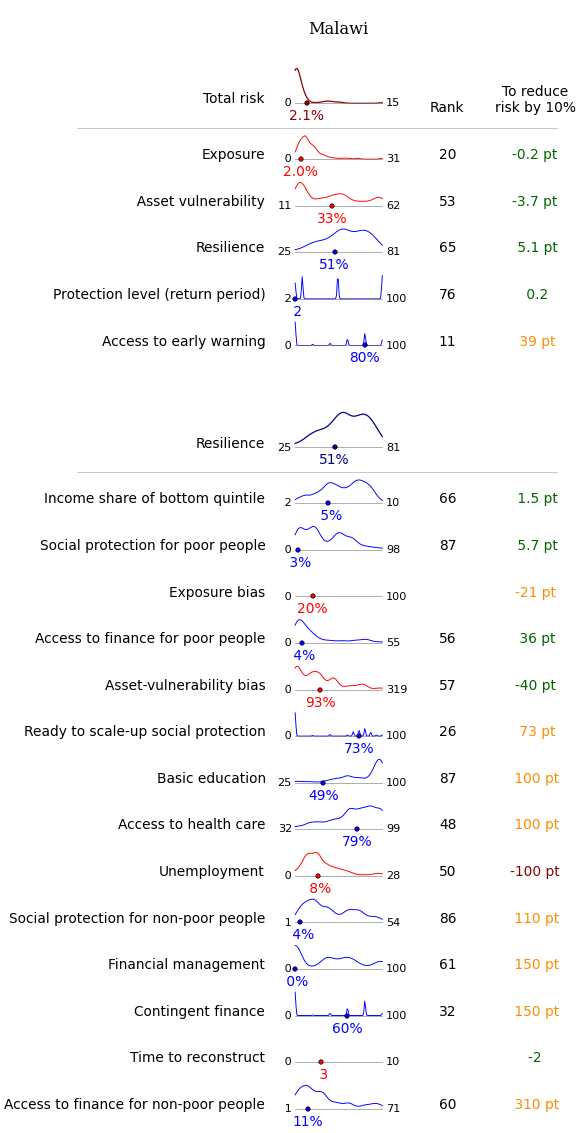

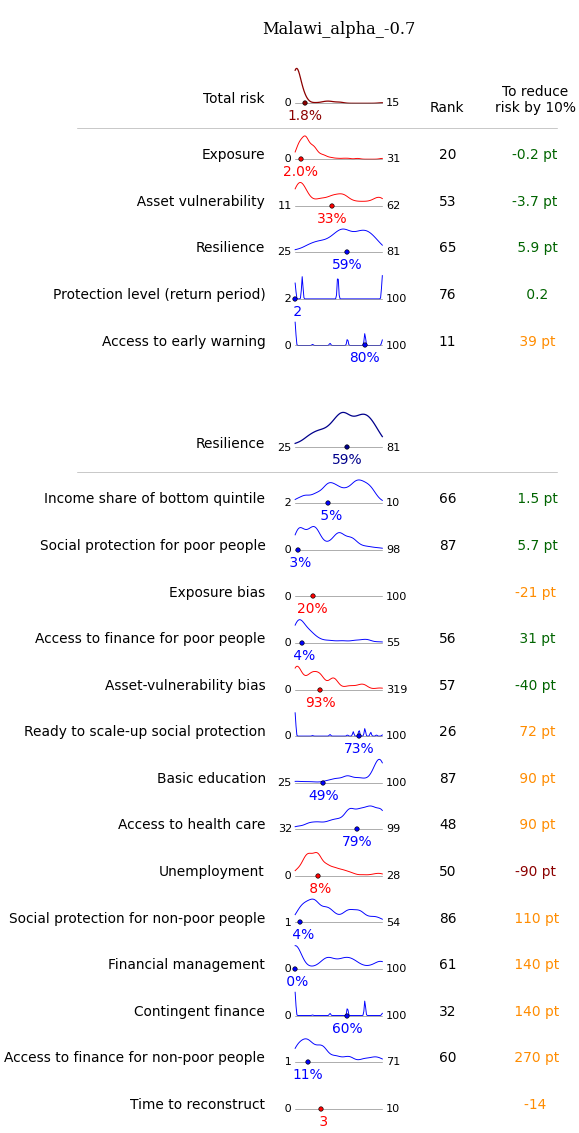

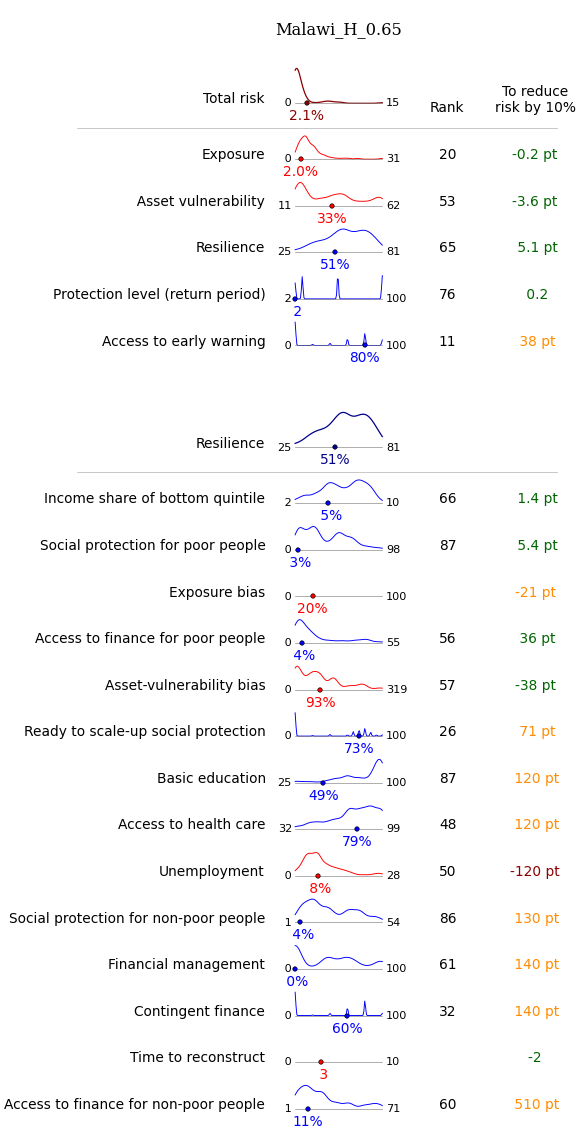

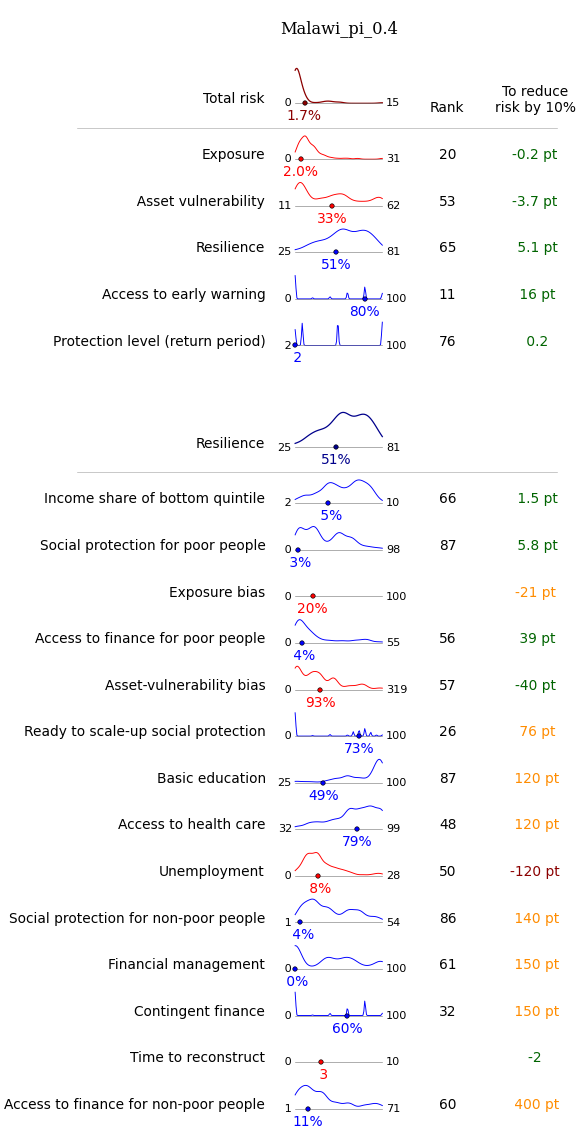

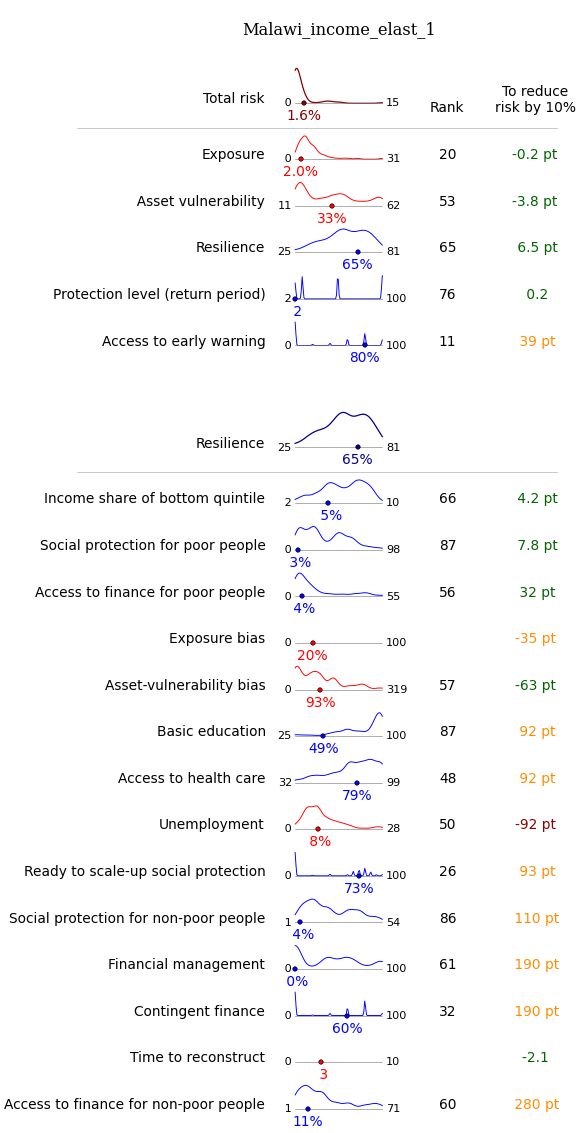

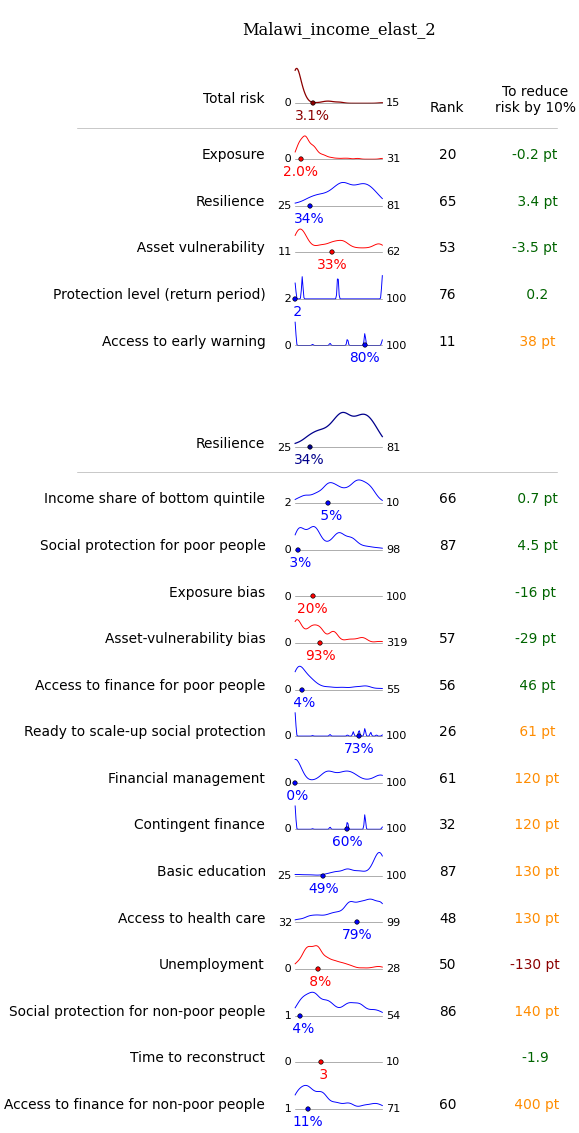

In [15]:
def report_current_country(c):
    #report progress
    clear_output()
    print(c)
    sys.stdout.flush()    

for c in country_list:
    report_current_country(c)
    #new figure
    fig=plt.figure(figsize=(8,32))
    i=0

    #sort keys
    risk_keys       = deriv_risk      .abs().ix[c][risk_keys      ].order(ascending=True).index.tolist()
    resilience_keys = deriv_resilience.abs().ix[c][resilience_keys].order(ascending=True).index.tolist()

    #steps wanted
    step_wanted_in_risk = 1/10 * df_with_sens.ix[c,"risk"]
    step_wanted_in_resilience = -step_wanted_in_risk/deriv_risk["resilience"][c]

    #resilience drivers
    for key in resilience_keys:
        i=draw_row(key,c,i,step_wanted_in_resilience/deriv_resilience)

    #separator
    i= draw_seprarator(i)

    #Resilience
    draw_distri("resilience",i,"DarkBlue",.3,.6,2)
    anotate_distri("resilience",c,i,"DarkBlue")

    #write_titles(i," ")

    i+=1.75

    #risk drivers
    for key in risk_keys:
        i=draw_row(key,c,i,-(step_wanted_in_risk/deriv_risk))

    #separator
    i= draw_seprarator(i)

    #risk
    draw_distri("risk",i,"DarkRed",.3,.6,2)
    anotate_distri("risk",c,i,"DarkRed")

    write_titles(i,"To reduce\nrisk by 10%")  

    #Country name
    plt.text(1/2,i+1.2,c,fontdict=bigfont,horizontalalignment="center")

    #plt.text(0,i+.8,resilience.ix[c],fontdict=bigfont,horizontalalignment="right")  

    #Settings
    plt.axis('off');
    plt.xlim(xmin=-0.2,xmax=3);
    plt.ylim(ymin=-.2,ymax=i+1.7); 
    subfolder = "elast_"+str( df_with_sens.ix[c,"income_elast"])+"/"
    os.makedirs(out_folder+subfolder,exist_ok=True)
    plt.savefig(out_folder+subfolder+c.lower().replace(" ","_")+".png",bbox_inches="tight")
    if not debug:
        if not c == country_list[-1]:
            plt.close()


